In [2]:
#import libraries
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
from datetime import datetime, timezone, timedelta
import datetime as dt
import random
import pandas as pd
import numpy as np
from snowflake.connector.pandas_tools import pd_writer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
#Connection setup and functions
class SFConnection:
    def __init__(self):
        self.name = ''
        self.connection = ''
        self.engine = ''

    def open_conn(self):
        username = self.name + ''

        self.engine = create_engine(URL(
        account = '',
        user = username,
        password = '',
        database = '',
        schema = '',
        warehouse = '',
        role='',
        authenticator='externalbrowser'
        ))
        self.connection = self.engine.connect().execution_options(autocommit=False)
        self.connection.begin()
        print("Connection Opened")

    def test_conn(self):
        try:
            self.open_conn()
            results = self.connection.execute('select current_version()').fetchone()
            print("Snowflake connected to Version: {}".format(results[0]))
            return("CONNECTED")
        except Exception as e:
            print("Snowflake connection Error")
            return("ERR")

    def run_query(self, sql):
        self.connection.execute("BEGIN")
        self.connection.execute(sql)
        self.connection.execute("COMMIT")

    def query_to_df(self, sql):
        #results = self.connection.execute(sql)
        return pd.read_sql_query(sql, self.connection)
        #return df_txn
        
    def close_conn(self):
        self.connection.close()
        print("Connection Closed")

    def add_name(self, name):
        self.name = name
    
    #accepts a dataframe and a table name in lowercase. It is fixed currently to the FBI Schema. You only need to pass through the tablename
    #The df must be in the exact format as table
    #This will upload in chuncks of 10,000 rows to Snowflake
    #This method will replace all current values from Dataframe 
    def load_dataframe_REPLACE(self, inputdf, tablename):
        inputdf.to_sql(name=tablename.lower(), con=self.engine, if_exists='replace', index=False, chunksize=10000)
    
    #Method for inserting value without replacing to data tables 
    def load_dataframe_APPEND(self, inputdf, tablename):
        inputdf.to_sql(name=tablename.lower(), con=self.engine, if_exists='append', index=False, chunksize=10000)

In [4]:
SQL = '''--Python Program to find the combination of data for all of the differen district combinations 
'''


#Connection String Created and Query Pulled
conn = SFConnection()
conn.add_name('NACKE08') #Change to Current User LDAP
conn.test_conn()
dfRESULTS = conn.query_to_df(SQL)
conn.close_conn()

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Connection Opened
Snowflake connected to Version: 8.10.1
Connection Closed


In [6]:
dfRESULTS.columns

Index(['district', 'week_id', 'num_households', 'num_txns', 'total_sales',
       'aov', 'num_txns_dug_pct', 'num_txns_delivery_pct', 'rpt_rate',
       'rph_30', 'rph_30_all'],
      dtype='object')

<AxesSubplot:>

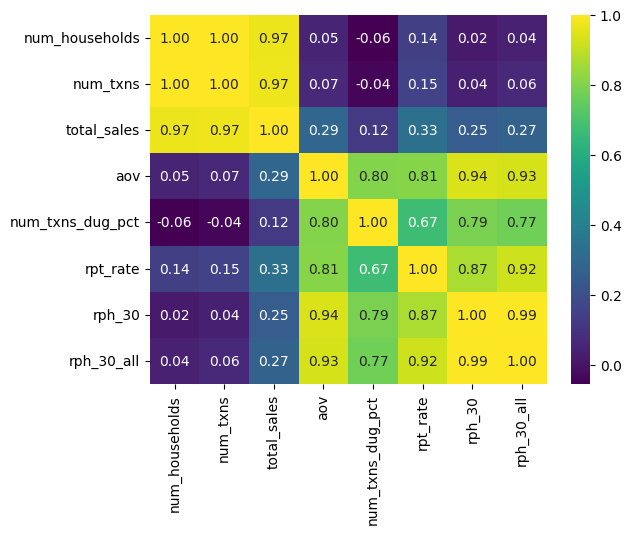

In [8]:
df_corr = dfRESULTS[['num_households', 'num_txns', 'total_sales',
       'aov', 'num_txns_dug_pct', 'rpt_rate',
       'rph_30', 'rph_30_all']].corr()

df_corr.head()

#<0.25 = No Relationship
#0.25-0.50 = Weak Relationship
#0.5- 0.75 = Moderate Relationship
#0.75-1.0 = Strong Relationship
sns.heatmap(df_corr, annot=True, cmap='viridis', fmt= '0.2f')